# Pitch Classification Intro
The purpose of this dataset is to work on a classification pipeline for the pitch type selection.

Importing various packages:

In [1]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Pickling in the data from data_cleaning.ipynb:

In [4]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project'

In [5]:
with open('./Data/cleaned_pitch_df.pickle','rb') as read_file:
    pitch_df = pickle.load(read_file)

In [6]:
pitch_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season,Pitch_Family
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,None,NaN,NaN,NaN,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
1,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,0.416,2.963,92.9,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
2,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.191,2.347,92.8,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
3,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.518,3.284,94.1,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,
4,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,FF,-0.641,1.221,91.0,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015,


In [7]:
pitch_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'Pitch_Family'],
      dtype='object')

In [8]:
pitch_df.drop(columns=['Pitch_Family'], inplace=True)

For classification purposes, I'll have the following features for now:
- 'inning', 'top', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed', 'pitcher_run_diff'
- I will be using 'pitch_type' as the label
- First attempt will be to train models on individual pitchers, using the same pipeline steps.  
- For now, I'll be using just this data to set up a workflow.  Once other data (namely, pitch arsenal and hitter clustering) are ready, they will be incorporated.

# Dataframe Prep

## Split: Train/Val and Test

For puposes of training/validating and testing my model(s), I'll be splitting as follows: 
- Train/Val: 2015-2018 seasons
- Test: 2019 season

In [9]:
pitch_df[pitch_df.Season == 2019].shape

(707463, 34)

In [10]:
pitch_df[pitch_df.Season != 2019].shape

(2848371, 34)

Based on the numbers, this is an ~80/20 split in data.

In [11]:
train_df = pitch_df[pitch_df.Season != 2019]

In [12]:
train_df.pitcher_full_name.value_counts()

Max Scherzer        13479
Justin Verlander    12810
Chris Archer        12760
Jose Quintana       12692
Chris Sale          12689
                    ...  
Alexi Amarista          3
Phillip Ervin           3
Mark Reynolds           3
Anthony Rizzo           2
Chris Denorfia          2
Name: pitcher_full_name, Length: 1329, dtype: int64

### First Pitch Types:

Right now, last pitch type, speed, and location is all null for the first pitch of an at-bat, since there aren't any other pitchs in that at bat.  To remove the null information, I will add in the first pitch from the *previous* at bat, since that could inform how a pitcher opens at bats.

In [82]:
pitchers = train_df.pitcher_full_name.value_counts().index

In [81]:
train_df[train_df.pitch_num == 1]

,inning,batter_id,pitcher_id,top,ab_id,p_score,stand,p_throws,event,home_team,...,pitch_num,last_pitch_type,last_pitch_px,last_pitch_pz,last_pitch_speed,pitcher_full_name,pitcher_run_diff,hitter_full_name,Date_Time_Date,Season
0,1.0,572761,452657,1.0,2.015000e+09,0.0,L,L,Groundout,chn,...,1.0,None,NaN,NaN,NaN,Jon Lester,0.0,Matt Carpenter,2015-04-05,2015
6,1.0,518792,452657,1.0,2.015000e+09,0.0,L,L,Double,chn,...,1.0,None,NaN,NaN,NaN,Jon Lester,0.0,Jason Heyward,2015-04-05,2015
8,1.0,407812,452657,1.0,2.015000e+09,0.0,R,L,Single,chn,...,1.0,None,NaN,NaN,NaN,Jon Lester,0.0,Matt Holliday,2015-04-05,2015
11,1.0,425509,452657,1.0,2.015000e+09,0.0,R,L,Strikeout,chn,...,1.0,None,NaN,NaN,NaN,Jon Lester,-1.0,Jhonny Peralta,2015-04-05,2015
14,1.0,571431,452657,1.0,2.015000e+09,0.0,L,L,Strikeout,chn,...,1.0,None,NaN,NaN,NaN,Jon Lester,-1.0,Matt Adams,2015-04-05,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2848347,9.0,543768,448802,1.0,2.018186e+09,1.0,L,L,Groundout,chn,...,1.0,None,NaN,NaN,NaN,Jaime Garcia,-2.0,Travis Shaw,2018-10-01,2018
2848350,9.0,502517,623352,0.0,2.018186e+09,3.0,L,L,Strikeout,chn,...,1.0,None,NaN,NaN,NaN,Josh Hader,2.0,Daniel Murphy,2018-10-01,2018
2848354,9.0,450314,623352,0.0,2.018186e+09,3.0,R,L,Flyout,chn,...,1.0,None,NaN,NaN,NaN,Josh Hader,2.0,Ben Zobrist,2018-10-01,2018
2848358,9.0,595879,623352,0.0,2.018186e+09,3.0,R,L,Single,chn,...,1.0,None,NaN,NaN,NaN,Josh Hader,2.0,Javier Baez,2018-10-01,2018


In [ ]:
for pitcher in pitchers:
    filtered_df = train_df[(train_df.pitcher_full_name == pitcher) & (train_df.pitch_num == 1)].sort_values(by=['ab_id'])
    first_pitches = filtered_df.index[1:]
    for i, first_pitch in enumerate(first_pitches, 1):
        last_first_pitch = train_df.pitch_type.iloc[filtered_df.index[i-1]]
        last_first_px = train_df.px.iloc[filtered_df.index[i-1]]
        last_first_pz = train_df.pz.iloc[filtered_df.index[i-1]]
        last_first_speed = train_df.start_speed.iloc[filtered_df.index[i-1]]
        
        train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
        train_df.last_pitch_px.iloc[first_pitch] = last_first_px
        train_df.last_pitch_pz.iloc[first_pitch] = last_first_pz
        train_df.last_pitch_speed.iloc[first_pitch] = last_first_speed
    

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-88-312eaf23d68d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_type.iloc[first_pitch] = last_first_pitch
<ipython-input-88-312eaf23d68d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.last_pitch_p

In [ ]:
filtered_df = train_df['pitch_type', 'px', 'pz', 'start_speed', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed'][(train_df.pitcher_full_name =='Lucas Giolito') & (train_df.pitch_num == 1)].sort_values(by=['ab_id'])

## Feature Prep

Here, I"ll be preparing the dataframe for modeling.  I'll be starting with just a subset of one pitcher's pitches as a proof of concept, using Max Scherzer's pitch totals, since he has the most of any pitcher.

In [13]:
scherzer_df = train_df[train_df.pitcher_full_name == 'Max Scherzer']

In [14]:
scherzer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   inning             13479 non-null  float64       
 1   batter_id          13479 non-null  int64         
 2   pitcher_id         13479 non-null  int64         
 3   top                13479 non-null  float64       
 4   ab_id              13479 non-null  float64       
 5   p_score            13479 non-null  float64       
 6   stand              13479 non-null  object        
 7   p_throws           13479 non-null  object        
 8   event              13479 non-null  object        
 9   home_team          13479 non-null  object        
 10  away_team          13479 non-null  object        
 11  b_score            13479 non-null  float64       
 12  on_1b              13479 non-null  float64       
 13  on_2b              13479 non-null  float64       
 14  o

The following columns will need to be one-hot encoded: 
- stand (hitter hand), p_throws (pitcher throwing hand), last_pitch_type

In [15]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type']

To run one-hot encoding, I'll be utilizing the column_ohe_maker function in pitch_cat_functions.py:

In [17]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project'

In [18]:
cd Pitch_Classification

/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification


In [19]:
from pitch_cat_functions import *

In [20]:
new_df = column_ohe_maker(scherzer_df, ohe_cols)

In [21]:
new_df.head()

,inning,batter_id,pitcher_id,top,ab_id,p_score,event,home_team,away_team,b_score,...,Date_Time_Date,Season,stand_R,last_pitch_type_CU,last_pitch_type_FC,last_pitch_type_FF,last_pitch_type_FT,last_pitch_type_SL,last_pitch_type_UN,last_pitch_type_None
2396,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2397,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2398,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2399,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2400,1.0,434158,453286,1.0,2.015001e+09,0.0,Walk,was,nyn,0.0,...,2015-04-06,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None'],
      dtype='object')

Excellent, those are now one-hot encoded.

In [23]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inning                13479 non-null  float64       
 1   batter_id             13479 non-null  int64         
 2   pitcher_id            13479 non-null  int64         
 3   top                   13479 non-null  float64       
 4   ab_id                 13479 non-null  float64       
 5   p_score               13479 non-null  float64       
 6   event                 13479 non-null  object        
 7   home_team             13479 non-null  object        
 8   away_team             13479 non-null  object        
 9   b_score               13479 non-null  float64       
 10  on_1b                 13479 non-null  float64       
 11  on_2b                 13479 non-null  float64       
 12  on_3b                 13479 non-null  float64       
 13  px         

## Numerical Conversaion of Target:

In order to represent the pitch_type as multiple classes, I'll need to convert the object values to numerical values.  This will be done via the pitch_type_to_num function in pitch_cat_functions.py.

In [24]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'CH': 2, 'CU': 3, 'FC': 4, 'FT': 5}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
output_df.pitch_type.value_counts()

FF    7117
SL    2639
CH    1856
CU    1090
FC     688
FT      89
Name: pitch_type, dtype: int64

In [26]:
output_df.Pitch_Type_Num.value_counts()

0    7117
1    2639
2    1856
3    1090
4     688
5      89
Name: Pitch_Type_Num, dtype: int64

The pitch types and codes match, so the function is behaving as anticipated.

In [27]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13479 entries, 2396 to 2824573
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   inning                13479 non-null  float64       
 1   batter_id             13479 non-null  int64         
 2   pitcher_id            13479 non-null  int64         
 3   top                   13479 non-null  float64       
 4   ab_id                 13479 non-null  float64       
 5   p_score               13479 non-null  float64       
 6   event                 13479 non-null  object        
 7   home_team             13479 non-null  object        
 8   away_team             13479 non-null  object        
 9   b_score               13479 non-null  float64       
 10  on_1b                 13479 non-null  float64       
 11  on_2b                 13479 non-null  float64       
 12  on_3b                 13479 non-null  float64       
 13  px         

## Random Forest Classification:

Here, I'll run Max Scherzer's pitches through a Random Forest classifier to predict pitch types, using K-Fold cross validation.

In [36]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_SL', 'last_pitch_type_UN',
       'last_pitch_type_None']

In [37]:
X = output_df[col]

In [38]:
y = output_df['Pitch_Type_Num']

Random Forest Results for Max Scherzer
Confusion Matrix for Fold 1
[[958 209 119  55  34   1]
 [309 186  33   8   5   0]
 [239  45  58  24  19   0]
 [169  15  27  12  11   0]
 [ 97   3  22  11  10   0]
 [ 14   1   2   0   0   0]]


Confusion Matrix for Fold 2
[[1010  209  114   58   24    1]
 [ 321  153   20   10    5    0]
 [ 230   41   69   28    9    1]
 [ 156    8   30   21    7    0]
 [  92    7   29   13   11    0]
 [  15    3    1    0    0    0]]


Confusion Matrix for Fold 3
[[1008  225  129   39   34    1]
 [ 299  181   46    3    5    1]
 [ 222   28   66   23   16    0]
 [ 156   10   20   17    9    0]
 [  91   11   17   10    7    0]
 [  21    0    0    1    0    0]]


Confusion Matrix for Fold 4
[[1009  203  117   64   41    2]
 [ 312  188   37   11    4    1]
 [ 221   42   54   27   11    1]
 [ 137    5   23   28   11    0]
 [  91    4   22    6    9    0]
 [  11    2    0    2    0    0]]


Confusion Matrix for Fold 5
[[1045  203  115   42   44    4]
 [ 296  159   31   1

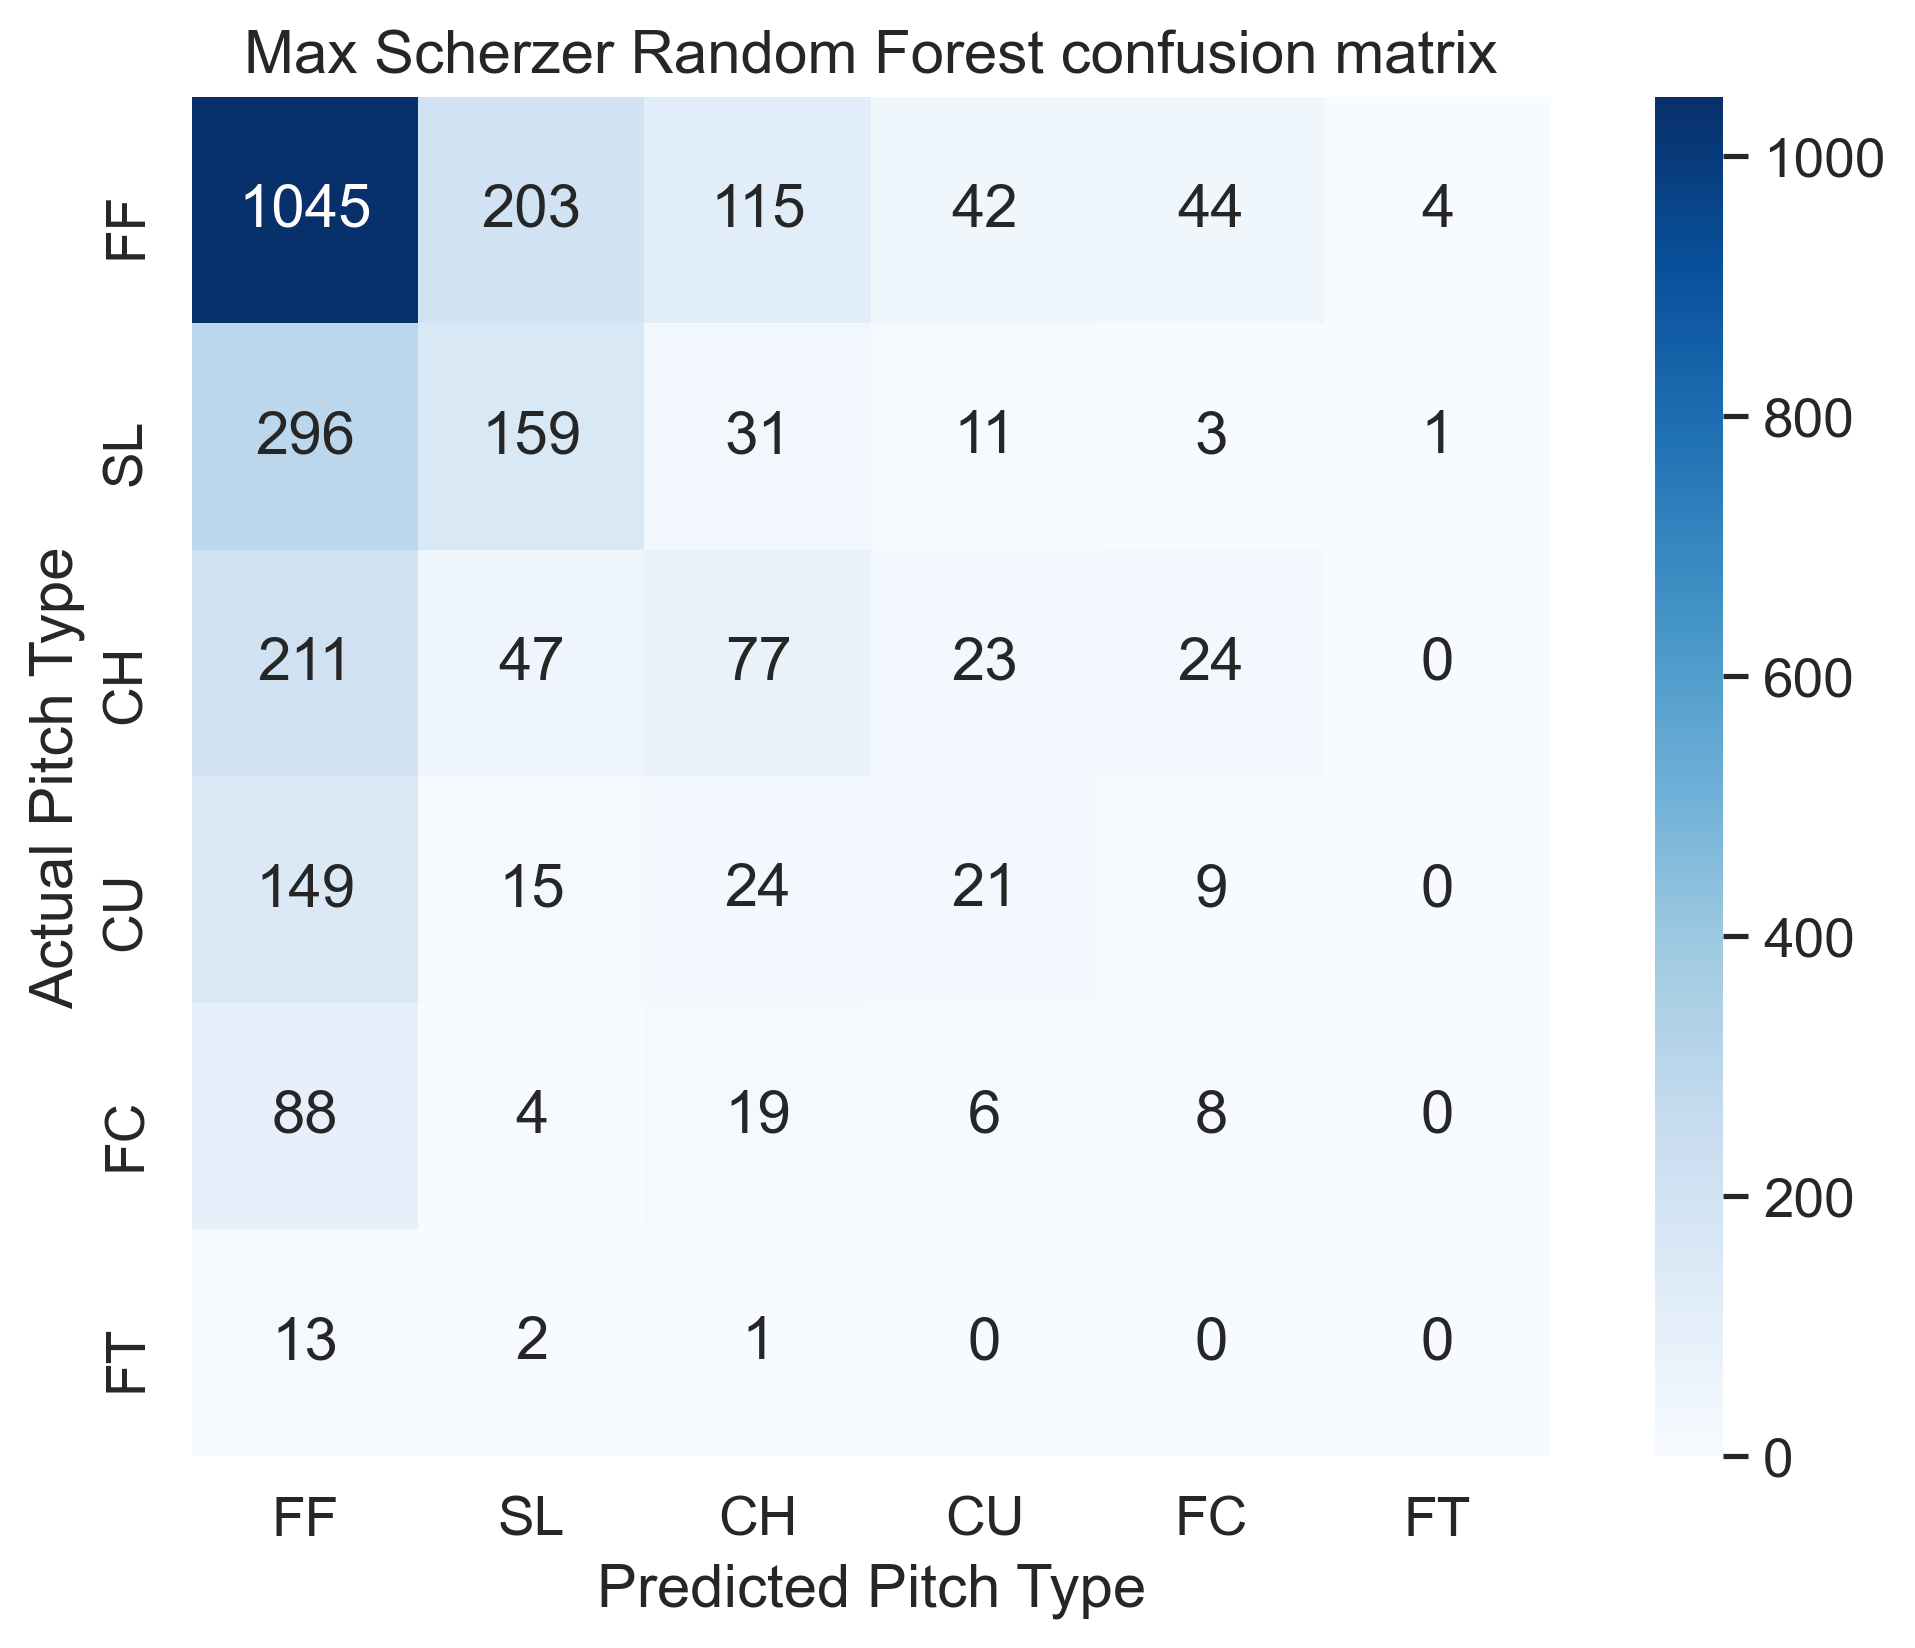

In [39]:
model = random_forest_eval_kfold('Max Scherzer',X,y, output_df,k=5, threshold = 0.5)

The model is doing it's best with four seam fastballs, which is good since that is the most commonly thrown pitch as shown in my EDA.  It is struggling (on the surface) with other pitch types, though.  I am hopeful that adding in the running rates of these pitchers that each pitcher throws will help with that.

For now, I am not going to mess with the hyperparameters of Random Forest until I see how that is going to turn out.

In the meantime, I'll test out the pipeline I've developed with some of the other pitchers in the dataset.

### RA Dickey

RA Dickey was a very heavy knuckleball pitcher.  I am curious to see how it works with him.

In [40]:
dickey_df = train_df[train_df.pitcher_full_name == 'R.A. Dickey']

In [42]:
new_df = column_ohe_maker(dickey_df, ohe_cols)

In [43]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'KN': 0, 'FF': 1, 'EP': 2}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [44]:
output_df.pitch_type.value_counts()

KN    7461
FF    1194
EP     203
Name: pitch_type, dtype: int64

In [45]:
output_df.Pitch_Type_Num.value_counts()

0    7461
1    1194
2     203
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [48]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None', 'Pitch_Type_Num'],
      dtype='object')

In [49]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_type_FF', 'last_pitch_type_KN', 'last_pitch_type_PO',
       'last_pitch_type_None']

In [50]:
X = output_df[col]

In [51]:
y = output_df['Pitch_Type_Num']

Random Forest Results for R.A. Dickey
Confusion Matrix for Fold 1
[[1407   60   10]
 [ 206   44    0]
 [  45    0    0]]


Confusion Matrix for Fold 2
[[1416   71    5]
 [ 191   50    0]
 [  39    0    0]]


Confusion Matrix for Fold 3
[[1396   77    6]
 [ 201   51    0]
 [  41    0    0]]


Confusion Matrix for Fold 4
[[1434   72    4]
 [ 178   42    0]
 [  40    0    1]]


Confusion Matrix for Fold 5
[[1411   80   12]
 [ 177   53    1]
 [  37    0    0]]




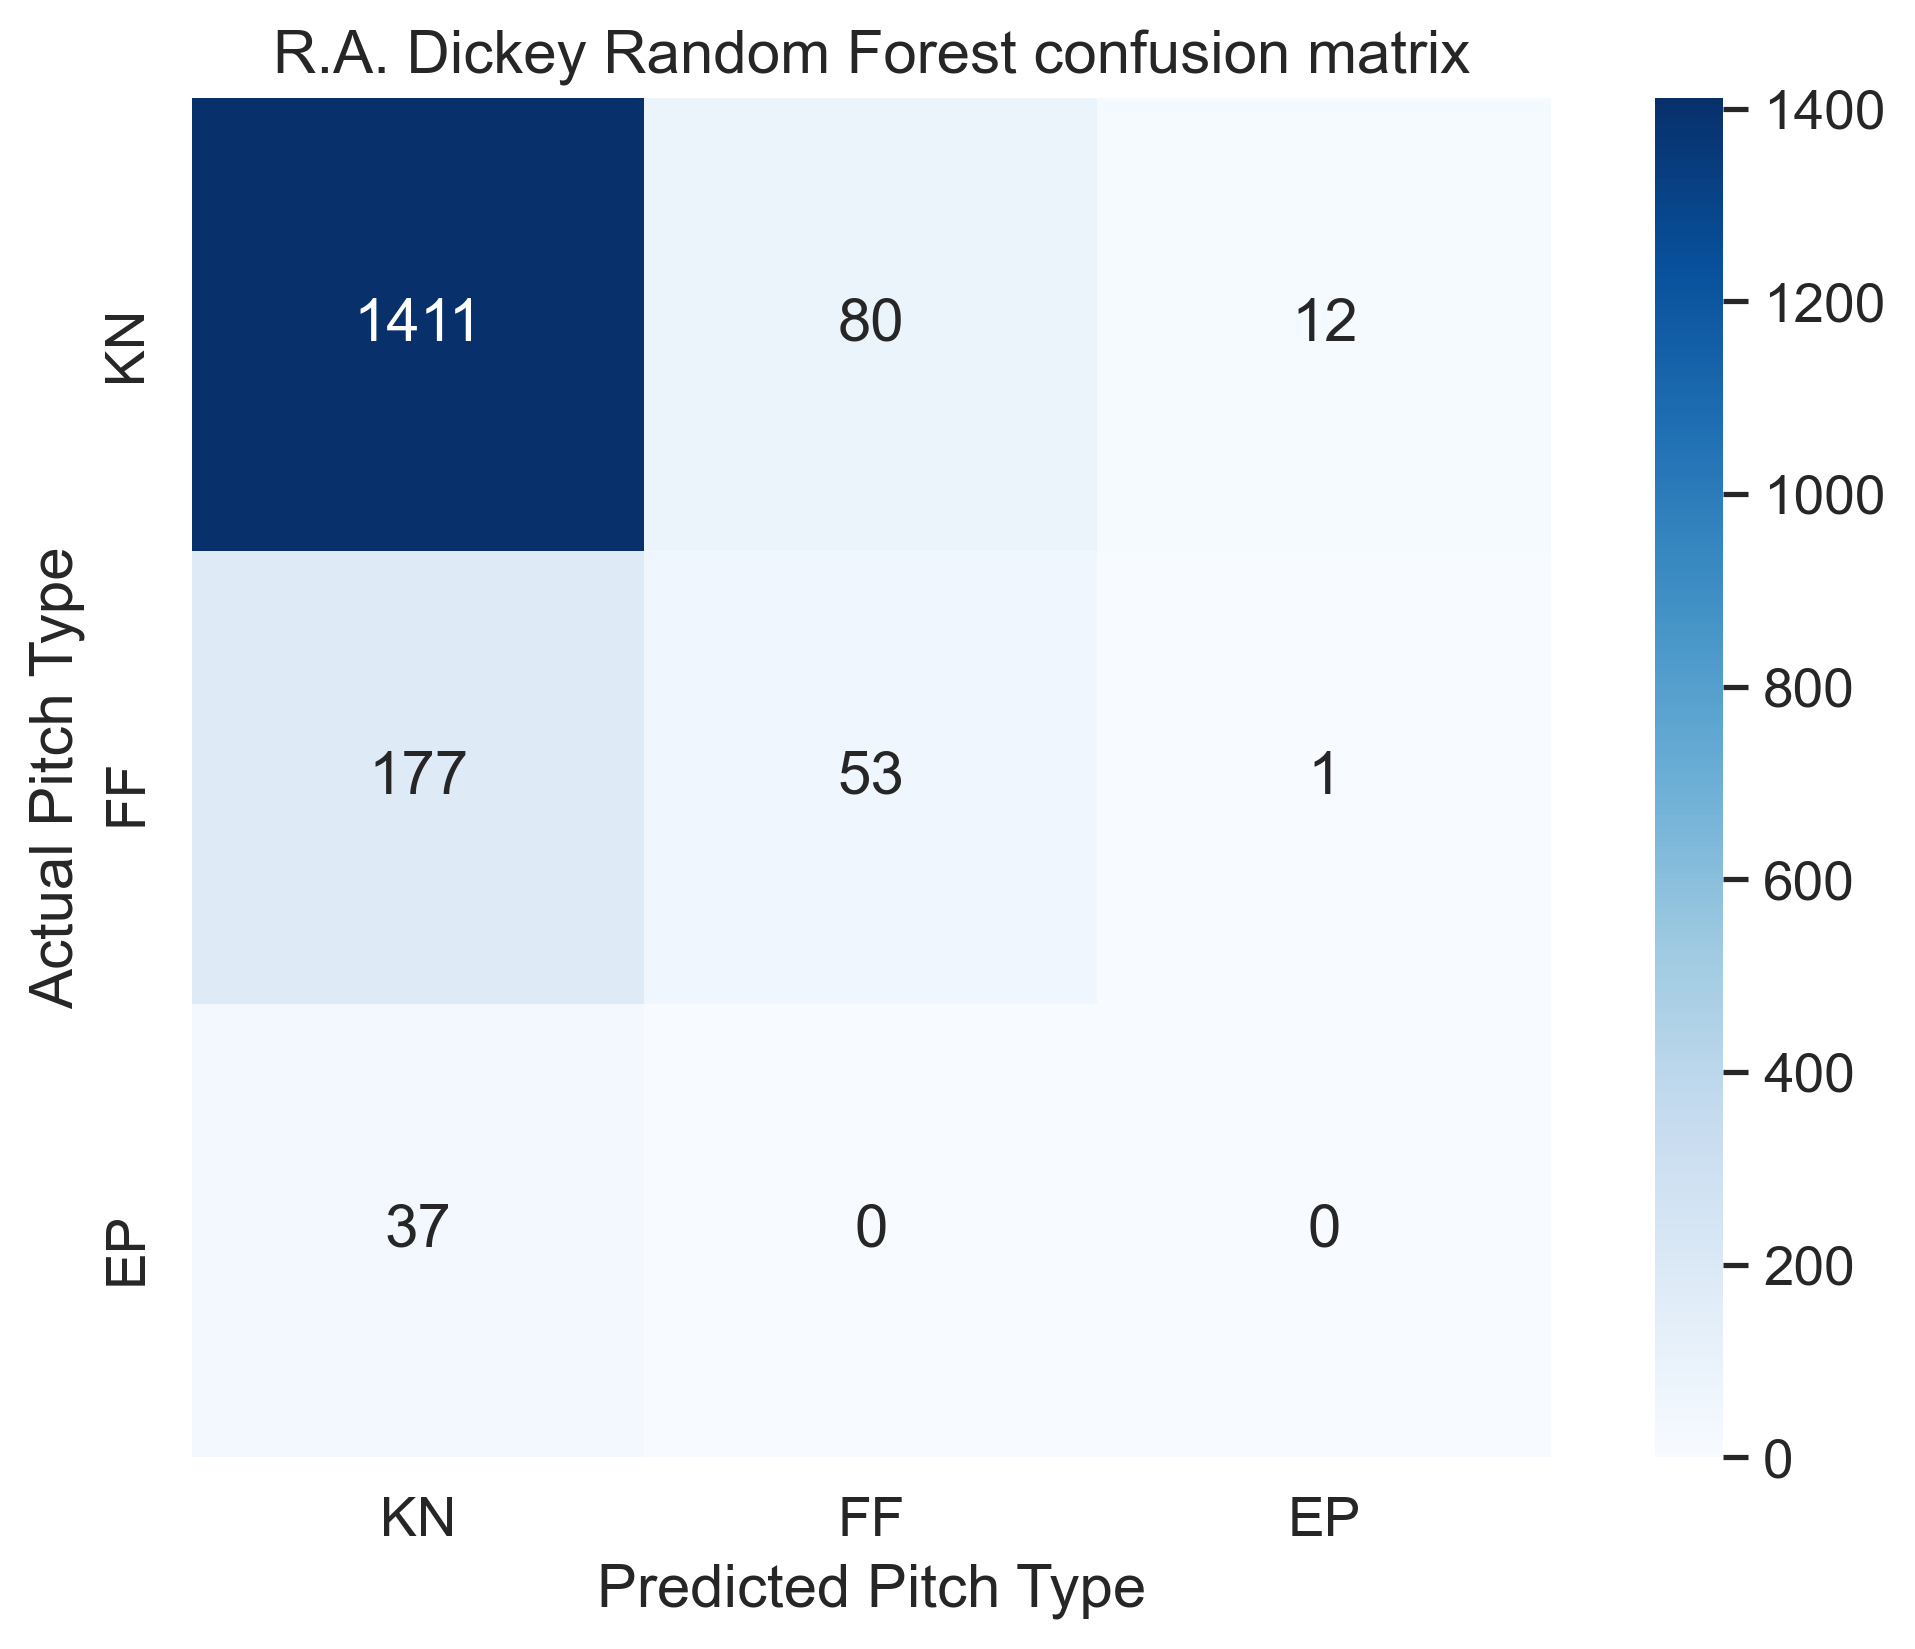

In [52]:
model = random_forest_eval_kfold('R.A. Dickey',X,y, output_df,k=5, threshold = 0.5)

Overall, again it is good with the knuckleball, his primary pitch.  The Four seamer isn't as great as I'd like.  I'm not really concerned with Eephus (EP), as that is a trick pitch where the pitcher throws it in super slow.

### Yu Darvish

Darvish will be another challenge case, as he throws a wide range of pitches.

In [56]:
darvish_df = train_df[train_df.pitcher_full_name == 'Yu Darvish']

In [57]:
new_df = column_ohe_maker(darvish_df, ohe_cols)

In [58]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'SL': 1, 'FT': 2, 'FC': 3, 'CU': 4, 'CH': 5, 'FS': 6, 'EP': 7}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [59]:
output_df.pitch_type.value_counts()

FF    1967
SL    1261
FT     969
FC     684
CU     328
CH     104
FS      37
EP       5
Name: pitch_type, dtype: int64

In [60]:
output_df.Pitch_Type_Num.value_counts()

0    1967
1    1261
2     969
3     684
4     328
5     104
6      37
7       5
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [61]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_EP', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_None', 'Pitch_Type_Num'],
      dtype='object')

In [62]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_EP', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_None']

In [63]:
X = output_df[col]

In [64]:
y = output_df['Pitch_Type_Num']

Random Forest Results for Yu Darvish
Confusion Matrix for Fold 1
[[212  61  62  33   8   4   0   0]
 [106  61  37  35   6   6   1   0]
 [ 87  40  53  30   4   1   2   0]
 [ 55  34  21  18   5   3   1   0]
 [ 27  17   6   4   3   1   0   0]
 [  5   4   5   2   1   1   0   0]
 [  5   2   1   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0]]


Confusion Matrix for Fold 2
[[216  64  43  22  12   7   1]
 [ 95  78  41  19  13   2   1]
 [ 85  31  60  13   4   3   1]
 [ 66  39  24  33   3   2   0]
 [ 32  22   7   3   7   3   0]
 [  8   2   2   1   1   1   0]
 [  1   1   1   1   0   0   0]]


Confusion Matrix for Fold 3
[[195  79  50  46  20   5   2   0]
 [ 98  86  22  23  13   2   2   0]
 [ 80  35  57  23   3   2   0   0]
 [ 44  34  17  20   3   1   0   0]
 [ 30  23   5   9   4   3   0   0]
 [  5   8   5   3   2   3   0   0]
 [  3   4   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0]]


Confusion Matrix for Fold 4
[[228  67  58  41  11   2   1   1]
 [100  83  37  18  15   1   0 

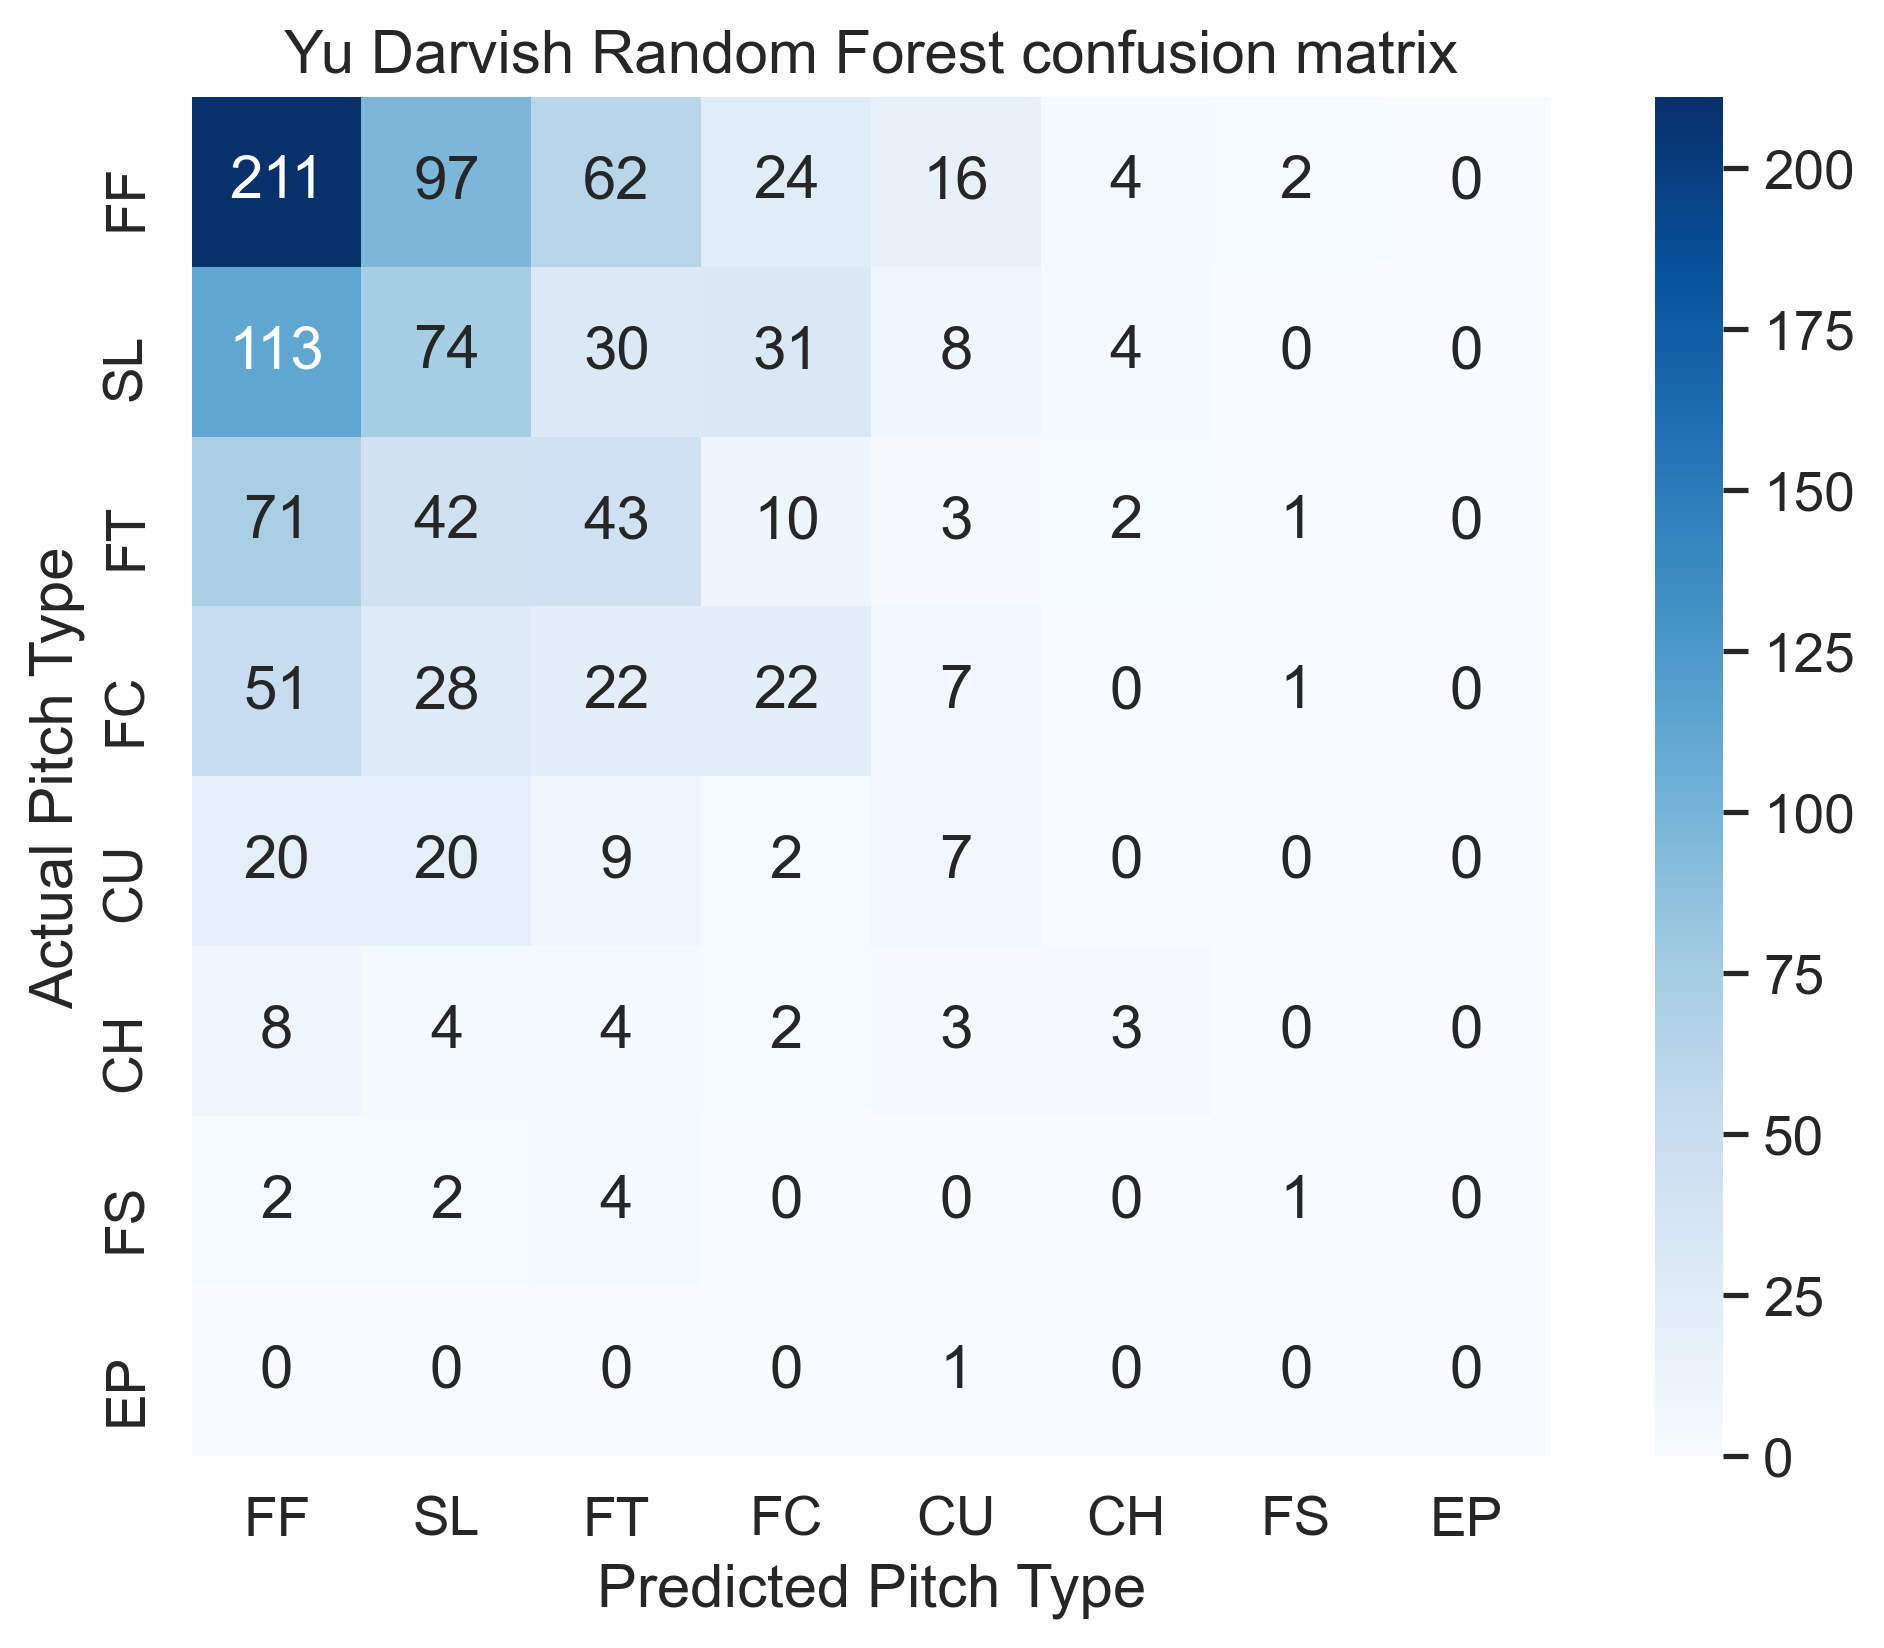

In [66]:
model = random_forest_eval_kfold('Yu Darvish',X,y, output_df,k=5, threshold = 0.5)

The model definitely challenges with Yu Darvish here.  This makes sense, since he throws so many types of pitches.  Once I have the pitch proportions this should improve in performance.

### Alex Colome

I am going to try with Colome, who is a reliever who heavily focuses on his cut fastball.

In [67]:
colome_df = train_df[train_df.pitcher_full_name == 'Alex Colome']

In [68]:
new_df = column_ohe_maker(colome_df, ohe_cols)

In [69]:
output_df = pitch_type_to_num(new_df, 'pitch_type')

Here is the coding for pitch type:
{'FF': 0, 'FC': 1, 'CH': 2, 'CU': 3, 'FT': 4}


/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [70]:
output_df.pitch_type.value_counts()

FF    2165
FC    2011
CH     295
CU     113
FT      55
Name: pitch_type, dtype: int64

In [71]:
output_df.Pitch_Type_Num.value_counts()

0    2165
1    2011
2     295
3     113
4      55
Name: Pitch_Type_Num, dtype: int64

Pitch counts match up, moving to RF modeling.

In [72]:
output_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'pitch_type', 'start_speed', 'type', 'b_count', 's_count',
       'outs', 'pitch_num', 'last_pitch_px', 'last_pitch_pz',
       'last_pitch_speed', 'pitcher_full_name', 'pitcher_run_diff',
       'hitter_full_name', 'Date_Time_Date', 'Season', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_None', 'Pitch_Type_Num'],
      dtype='object')

In [73]:
col = ['inning', 'top', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'stand_R',
       'last_pitch_type_CU', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FT', 'last_pitch_type_None']

In [74]:
X = output_df[col]

In [75]:
y = output_df['Pitch_Type_Num']

Random Forest Results for Alex Colome
Confusion Matrix for Fold 1
[[274 131  14   5   3]
 [138 269   7   2   1]
 [ 28  16   6   1   0]
 [ 11  10   1   1   1]
 [  5   3   1   0   0]]


Confusion Matrix for Fold 2
[[264 141  12   4   3]
 [130 263  11   5   1]
 [ 32  24   4   2   1]
 [  7   7   3   2   1]
 [  4   2   4   1   0]]


Confusion Matrix for Fold 3
[[289 148  17   4   1]
 [120 235  10   1   1]
 [ 38  19   8   1   1]
 [ 12   7   0   2   0]
 [  8   2   3   1   0]]


Confusion Matrix for Fold 4
[[277 128  17   4   2]
 [133 268   6   5   1]
 [ 31  16   7   2   1]
 [ 11   4   1   0   2]
 [  7   4   0   0   1]]


Confusion Matrix for Fold 5
[[285 120  18   2   2]
 [133 252  12   4   3]
 [ 35  16   4   2   0]
 [ 14  13   1   2   0]
 [  9   0   0   0   0]]




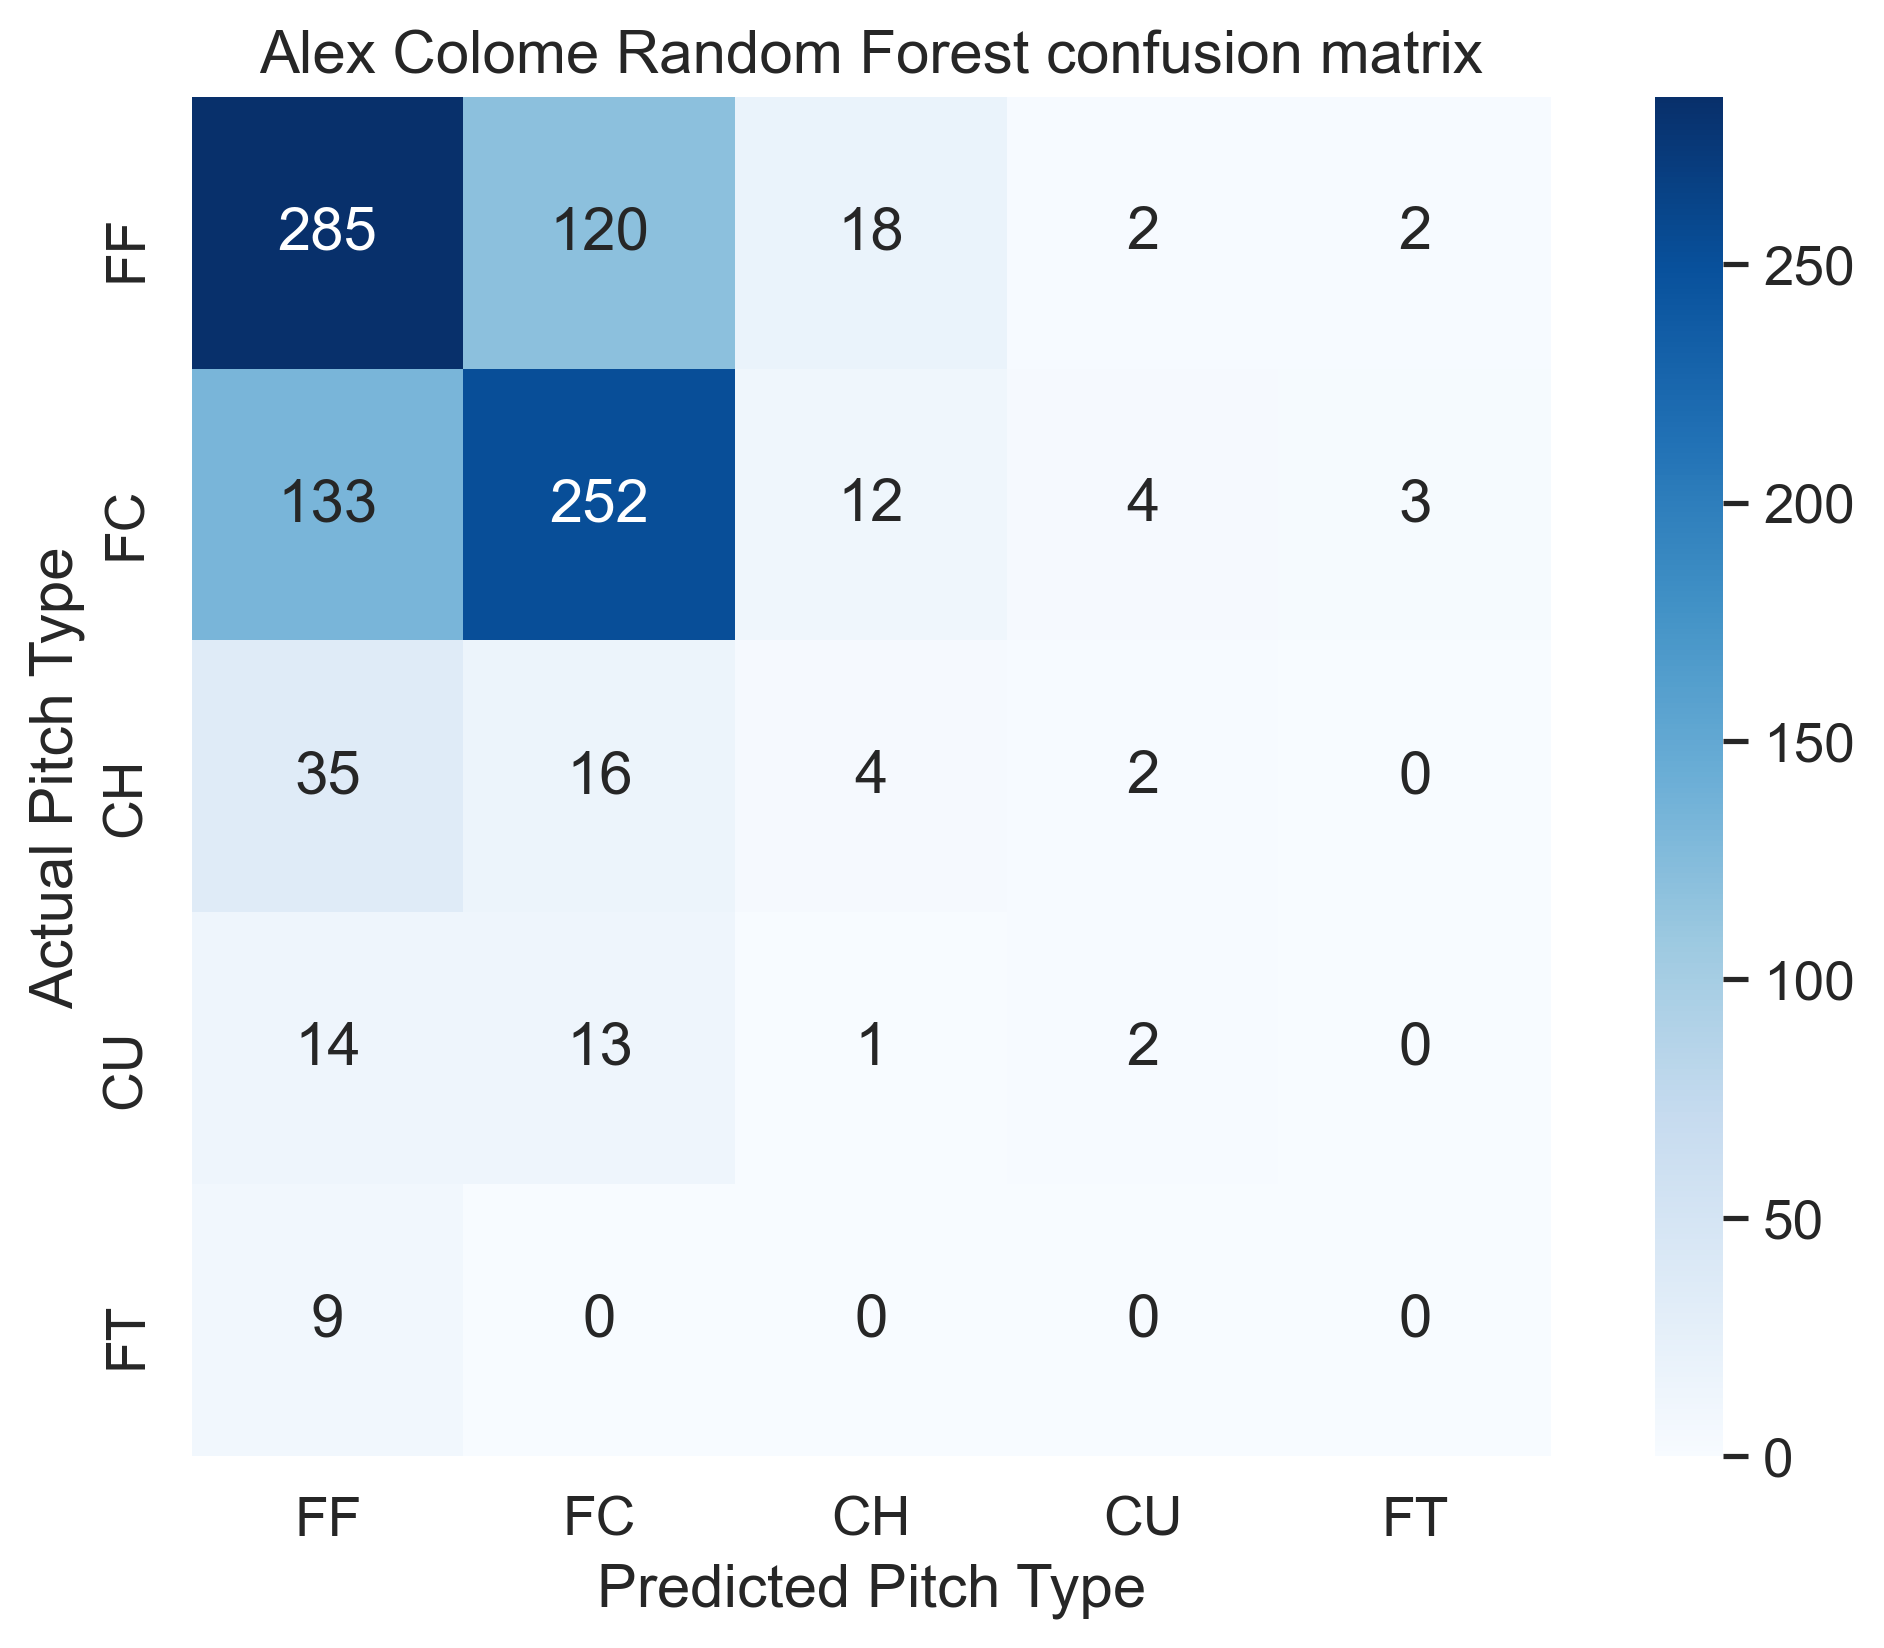

In [76]:
model = random_forest_eval_kfold('Alex Colome',X,y, output_df,k=5, threshold = 0.5)

Overall, this has decent performance on the four-seamer and cutter, which are his primary pitches.  Based on what I am seeing so far, the model is doing a good job with the higher usage pitches, and struggling with lesser-used ones.